In [1]:
import numpy as np
import torch
from torch import nn
import torch.distributions as dist
import scipy.stats as st
import pandas as pd
import math
import os
import arviz as az
from statistics import mean
from IPython.display import display, Latex
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {'text.usetex' : True,
          'font.size' : 9,
          'font.family' : 'lmodern'
          }
plt.rcParams.update(params) 
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import warnings
warnings.filterwarnings("ignore")

from networks import *

/Users/sharmila/anaconda3/envs/py36_tf2/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  app.launch_new_instance()


In [2]:
results_dir = os.path.join(os.getcwd(), 'results_metrics/')

In [3]:
sns.set_context("paper")
sns.set_style("ticks")
def plot(kstest_stats, d_xi):
    #mpl.rcParams.update(mpl.rcParamsDefault)
    #plt.rcParams.update({'font.size': 9})
    
    width = 7.5/2
    height = width/1.6
    figure, ax = plt.subplots(figsize=(width, height)) #figsize=(8, 6)
    df = pd.DataFrame({'col':kstest_stats})
    y, x, _=plt.hist(kstest_stats, bins = 30) #, label='Histogram of relative error in ' + title
    #plt.grid(True)
    #plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel("KS test statistic of " + r'$\xi_{%.0f}$' % (d_xi+1))
    plt.ylabel("Count",rotation=0)
    ax.yaxis.set_label_coords(0.0, 1.05)
    sns.despine(trim=True)
    plt.tight_layout(pad=0.1)
    plt.savefig('hist_kstest_stats_parameter'+ str(d_xi+1) +'.pdf', dpi=300, bbox_inches='tight')
    plt.show()

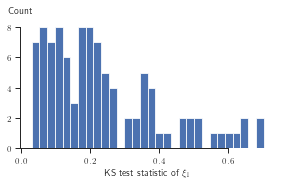

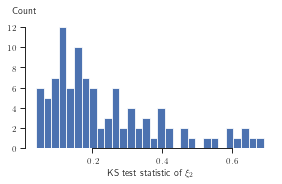

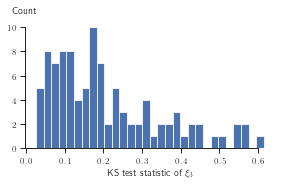

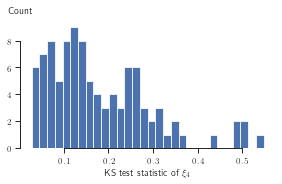

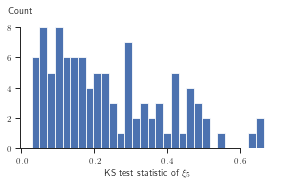

In [4]:
for d_xi in range(5):
    kstest_stats = []
    
    for j in range(100):
        xi_samples_AVI = torch.load(results_dir +str(j)+'_AVI'+'_xi_samples.pt')
        xi_samples_MCMC = torch.load(results_dir +str(j)+'_MCMC'+'_xi_samples.pt')
        kstest_stat, _ = st.kstest(xi_samples_AVI[:,d_xi].detach().numpy(), xi_samples_MCMC[:,d_xi].detach().numpy())
        kstest_stats.append(kstest_stat)
    plot(kstest_stats, d_xi)    

In [5]:
d_xi = 5 #  number of terms to consider

x_gt = torch.linspace(0., 1, 100)
x_ticks = torch.linspace(0.15, 0.85, 9) # Measurements of output at this x-locations
print(x_ticks)


# loading trained pinn model
pinn_state_dict = torch.load('model_state_dict_pinn.pt')
pinn = DenseResNet(dim_in=1+(d_xi), dim_out=1, num_resnet_blocks=5, 
                 num_layers_per_block=3, num_neurons=40, activation=nn.SiLU())
pinn.load_state_dict(pinn_state_dict)

B1 = 1 # boundary_value_left
B2 = 0 # boundary_value_right
u_trail = lambda x, inputs, net: (B1*(1-x))+(B2*x)+(x*(1-x)*net(inputs))


def forward_process(xi): # N x d_xi
    """
    Implements the forward process f(xi) and 
    returns the output field values at the measurement locations.
    """
    xi = xi.reshape(-1,d_xi)
    outputs = torch.zeros(xi.shape[0], len(x_ticks))
    for i in range(xi.shape[0]):
        inputs_i = torch.hstack([x_ticks.reshape(-1,1), xi[i].repeat(len(x_ticks),1)])
        u_pred_i = u_trail(x_ticks.reshape(-1,1), inputs_i, pinn) 
        outputs[i] = u_pred_i.flatten()
    return outputs

tensor([0.1500, 0.2375, 0.3250, 0.4125, 0.5000, 0.5875, 0.6750, 0.7625, 0.8500])


In [6]:
xi_data, y_data = torch.load(results_dir +'xi_data.pt'), torch.load(results_dir +'y_data.pt')
xi_data.shape, y_data.shape

(torch.Size([100, 5]), torch.Size([100, 9]))

In [7]:
metric = 0
for j in range(100):
    
    xi_samples_AVI = torch.load(results_dir +str(j)+'_AVI'+'_xi_samples.pt')
    diff = forward_process(xi_samples_AVI) - forward_process(xi_data[j].reshape(1,-1))
    #print(diff.shape)
    
    metric += torch.linalg.norm(diff, 2, dim=1).mean()
    
print(metric/100)

tensor(0.0405, grad_fn=<DivBackward0>)


In [8]:
4.05*1e-2

0.0405